In [1]:
from IPython.display import display, Markdown
with open("README.md") as f:
    display(Markdown(f.read()))

# LCWS2021

This is not supposed to replace the
[LCWS repository](https://github.com/LLR-ILD/LCWS2021).
The MC1/MC2 random split procedure changed,
so small differences are to be expected.
Fill this example to:

- Have a place to look at when wondering what plotting utility is
  still missing.
- Have some plots that are comparable for a code cross check.

Most likely, we will simply delete this folder soon.


## Setup

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
from pathlib import Path

import alldecays
import alldecays.plotting as ap

In [3]:
img = Path("img")
img.mkdir(exist_ok=True)
decay_names = ["H→cc", "H→bb", "H→μμ", "H→ττ", "H→Zγ", "H→gg", "H→γγ", "H→ZZ", "H→WW"]
_brs = {
    # "H→ss":     0.00034,
    "H→cc":     0.02718,
    "H→bb":     0.57720,
    "H→μμ":     0.00030,
    "H→ττ":     0.06198,
    "H→Zγ":     0.00170,
    "H→gg": 0.08516+0.00034,
    "H→γγ":     0.00242,
    "H→ZZ":    0.02616,
    "H→WW":     0.21756,
}
brs = np.array(list(_brs.values()))

scenarios = {}
for csv_file in Path("data").glob("*.csv"):
    ds = alldecays.DataSet(decay_names, polarization=None, data_brs=brs)
    ds.add_channel("higgs", csv_file)
    ds.signal_scaler = .1  # Assumed efficiency for the analysis.
    ds.luminosity_ifb = 2000
    scenarios[csv_file.stem] = alldecays.Fit(ds)

expected_scenarios = set([
    "default", 
    "highly_correlated",
    "overlay_free_higher_stats", 
    "overlay_free", 
])
assert expected_scenarios == set(scenarios), set(scenarios)

INFO: The chosen minimizer plugin GaussianLeastSquares does not enforce the branching ratios to sum to 1. 
      On top of being conceptually problematic, this will break if the signal cross section does not match with the expectation.
INFO: The chosen minimizer plugin GaussianLeastSquares does not enforce the branching ratios to sum to 1. 
      On top of being conceptually problematic, this will break if the signal cross section does not match with the expectation.
INFO: The chosen minimizer plugin GaussianLeastSquares does not enforce the branching ratios to sum to 1. 
      On top of being conceptually problematic, this will break if the signal cross section does not match with the expectation.
INFO: The chosen minimizer plugin GaussianLeastSquares does not enforce the branching ratios to sum to 1. 
      On top of being conceptually problematic, this will break if the signal cross section does not match with the expectation.


## Single-scenario plots

Choose one of the available scenarios for this part

In [4]:
n_toys = 100     # Fast
# n_toys = 10_000  # LCWS value.
name = "default"
fit = scenarios[name]
fit.fill_toys(n_toys=100)


100%|██████████| 100/100 [00:00<00:00, 215.92 toy minimizations/s, 0 not accurate, 0 invalid]


ToyValues(100 draws)

In [5]:
(img / name).mkdir(exist_ok=True)
figs = ap.all_plots(fit, img / name,
    experiment_tag="ILD_preliminary",
)
plt.close("all")  # To not clutter this cell's output with all figures.

/home/kunath/alldecays/src/alldecays/plotting/toys/toy_hists.py:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
Plots skipped: _channel_counts not filled for the toys. 
Set `store_channel_counts=True` in fit.fill_toys (Usually a few 
(<< 100) toys are enough for diagnostics).


higgs:expected_counts


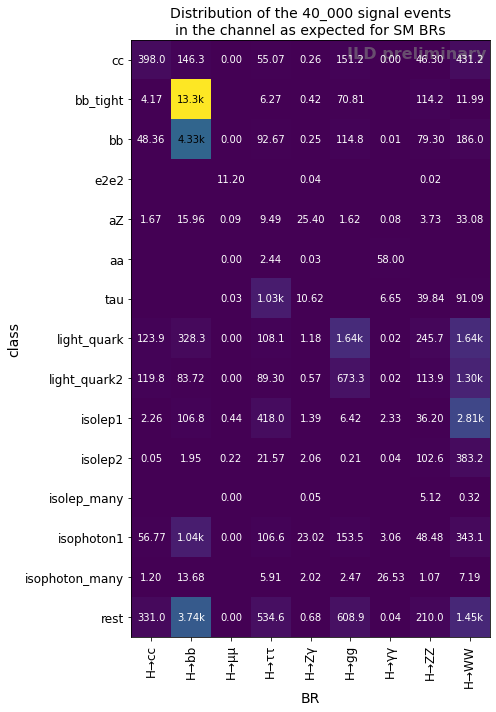

higgs:probability_matrix


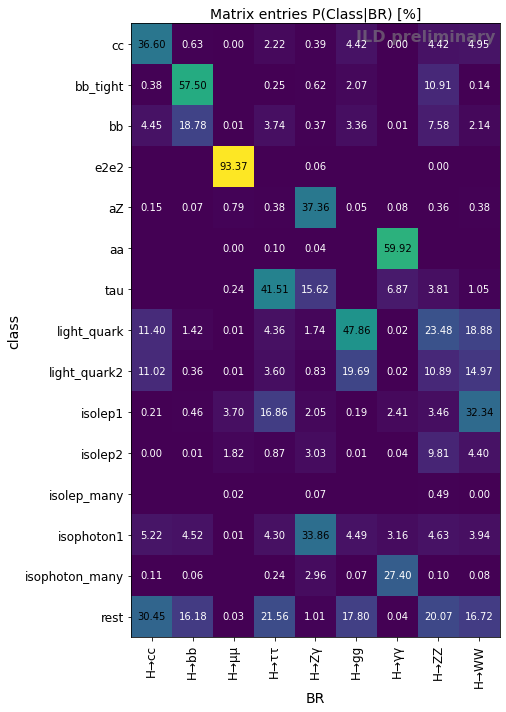

higgs:box_counts


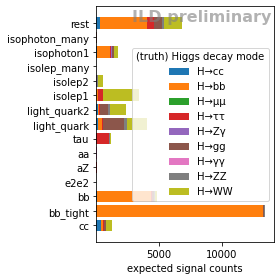

higgs:sample_counts


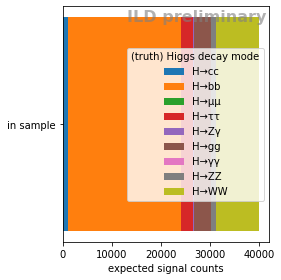

higgs:box_contributions


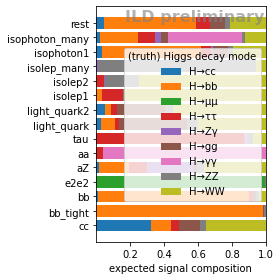

correlations_internal_from_toys


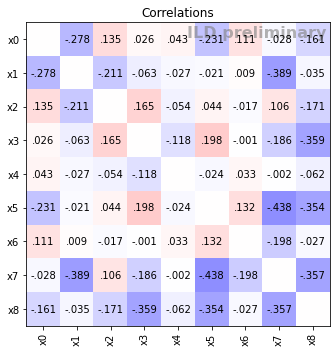

correlations_internal


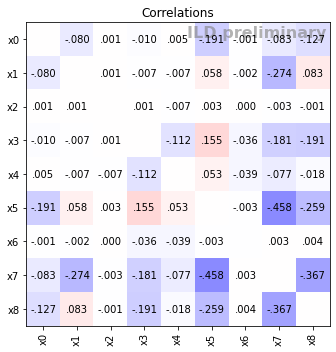

correlations_physics_from_toys


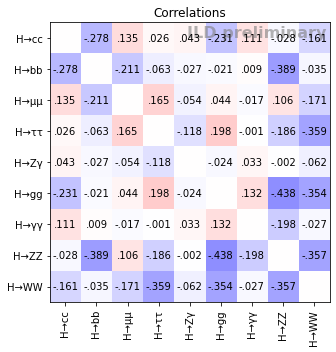

correlations_physics


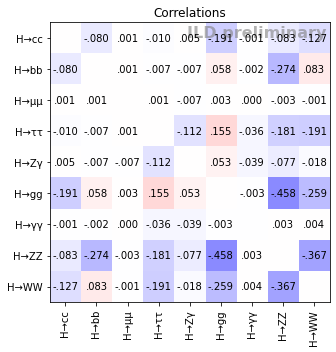

fit_values


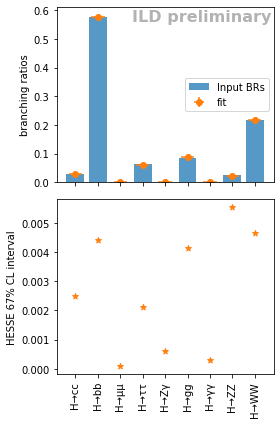

fit_errors


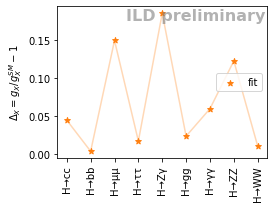

In [6]:
for f in figs:
    if not f.startswith("toys:"):
        print(f)
        display(figs[f])

toys:toy_hists_internal:x0


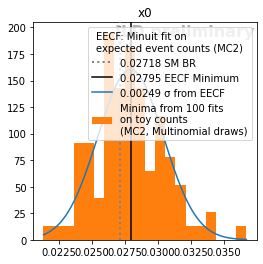

toys:toy_hists_internal:x1


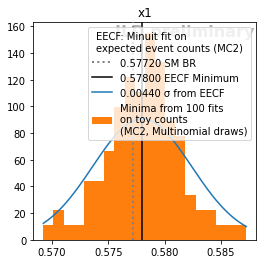

toys:toy_hists_internal:x2


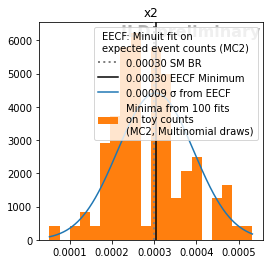

toys:toy_hists_internal:x3


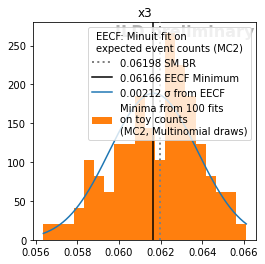

toys:toy_hists_internal:x4


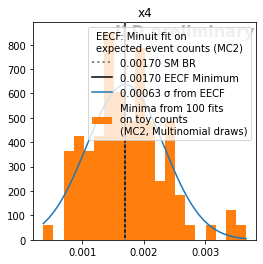

toys:toy_hists_internal:x5


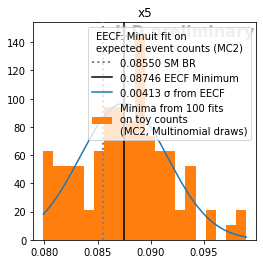

toys:toy_hists_internal:x6


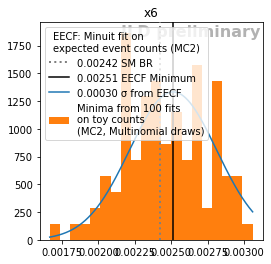

toys:toy_hists_internal:x7


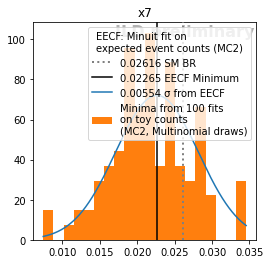

toys:toy_hists_internal:x8


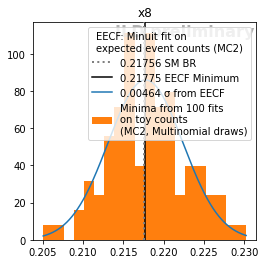

toys:toy_hists_physics:H→cc


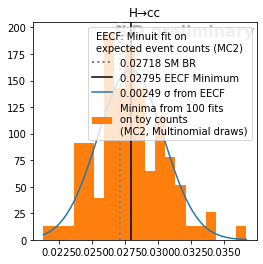

toys:toy_hists_physics:H→bb


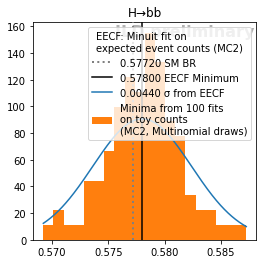

toys:toy_hists_physics:H→μμ


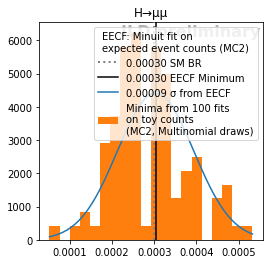

toys:toy_hists_physics:H→ττ


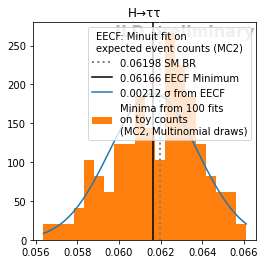

toys:toy_hists_physics:H→Zγ


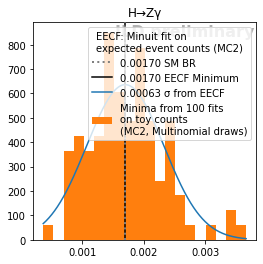

toys:toy_hists_physics:H→gg


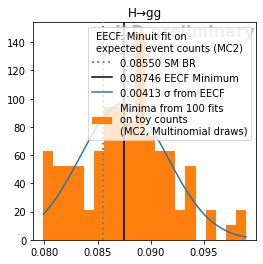

toys:toy_hists_physics:H→γγ


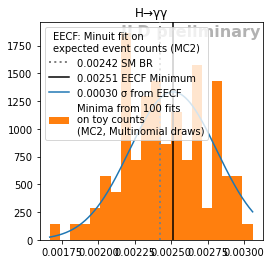

toys:toy_hists_physics:H→ZZ


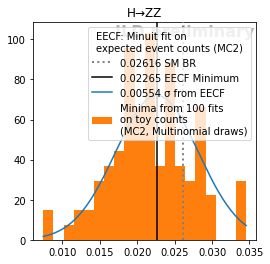

toys:toy_hists_physics:H→WW


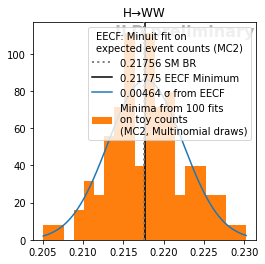

In [7]:
for f in figs:
    if f.startswith("toys:"):
        print(f)
        display(figs[f])

## Comparison plots

Optionally try to load the external scenarios from `../higgs_couplings_others.py`

In [8]:
sys.path.append(str(Path("../").absolute()))
try:
    from higgs_couplings_others import coupling_projections
except (ModuleNotFoundError, ImportError) as e:
    print(f"{type(e).__name__}: {e}")
    print("No external fits will be used in the comparison.")
    coupling_projections = {}
else:
    assert len(coupling_projections) == 2, "Change the local file if not."

compare_fits = {}
for k, error_dict in coupling_projections.items():
    names = list(error_dict.keys())
    values = [_brs[n] for n in names]
    # coupling_projections is citing relative coupling errors.
    # `* 2` to move to BRs. `* br` to move to total errors. 
    errors = [error_dict[n] * 2 * _brs[n] for n in names]
    compare_fits[k] = alldecays.plotting.util.FitParameters(
        names=names,
        values=values,
        errors=errors,
        covariance=None,
        starting_values=None,
    )

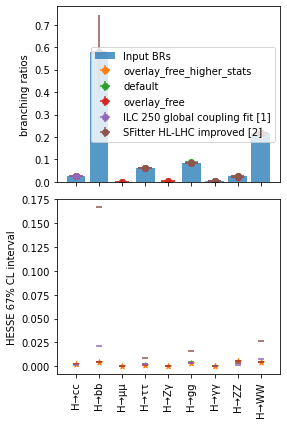

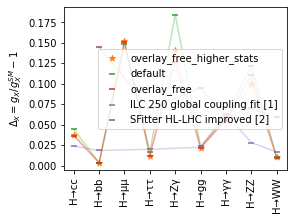

In [10]:
fits = {k: v for k, v in scenarios.items()}
fits.update(compare_fits)
fits.pop("highly_correlated")

ap.compare_values(fits)
ap.compare_errors_only(fits);